# Técnicas de regresión usando el módulo `basis-expansions` de [Matthew Drury](https://github.com/madrury)

Para poder usar este módulo habrá que instalarlo previamente, ya sea directamente a través de GitHub, con la siguiente línea de comandos:

    pip install git+https://github.com/madrury/basis-expansions.git
    
o bien tras haber descargado los ficheros fuente a nuestro ordenador y ejecutando el fichero   `setup.py` con la línea de comandos

    pip install .
    
tras habernos situado en el directorio adecuado en una ventana de Anaconda Prompt del entorno de Python con el que vayamos a trabajar:

    cd basis-expansions-master


In [7]:
%load_ext autoreload
%autoreload 2

from itertools import product
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from basis_expansions import (Binner,
                              GaussianKernel,
                              Polynomial, 
                              LinearSpline, 
                              CubicSpline,
                              NaturalCubicSpline)
from dftransformers import ColumnSelector, FeatureUnion, Intercept, MapFeature

from simulation import (run_simulation_expreiment, 
                        plot_simulation_expreiment, 
                        make_random_train_test,
                        run_residual_simulation)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Ejemplos Aplicados a Series, y creando Data Frames

In [8]:
s1 = pd.Series([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], name='s', 
              index=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'])
s2 = pd.Series([2, 3, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24], name='s', 
              index=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'])

df = pd.DataFrame({'s1': s1, 's2': s2})

In [3]:
df

,s1,s2
a,0,2
b,1,3
c,2,6
d,3,8
e,4,10
f,5,12
g,6,14
h,7,16
i,8,18
j,9,20


In [ ]:
df.shape

In [9]:
t = FeatureUnion([
    ('intercept', Intercept()),
    ('s1_pipe', Pipeline([
        ('s1_selector', ColumnSelector(name='s1')),
        ('s1_features', FeatureUnion([
            ('s1_spline', NaturalCubicSpline(knots=[4, 8, 10])),
            ('s1_indicator', MapFeature(lambda t: t % 2 == 0, 'is_even'))
        ]))
    ])),
    ('s2_pipe', Pipeline([
        ('s2_selector', ColumnSelector(name='s2')),
        ('s2_spline', NaturalCubicSpline(knots=[4, 8, 10]))  
    ]))
])

In [6]:
t.fit(df)
t.transform(df)

,intercept,s1_spline_linear,s1_spline_0,is_even,s2_spline_linear,s2_spline_0
a,1.0,0.0,0.000000,1.0,2.0,0.000000
b,1.0,1.0,0.000000,0.0,3.0,0.000000
c,1.0,2.0,0.000000,1.0,6.0,1.333333
d,1.0,3.0,0.000000,0.0,8.0,10.666667
e,1.0,4.0,0.000000,1.0,10.0,32.000000
f,1.0,5.0,0.166667,0.0,12.0,56.000000
g,1.0,6.0,1.333333,1.0,14.0,80.000000
h,1.0,7.0,4.500000,0.0,16.0,104.000000
i,1.0,8.0,10.666667,1.0,18.0,128.000000
j,1.0,9.0,20.333333,0.0,20.0,152.000000


In [10]:
t = FeatureUnion([
    ('intercept', Intercept()),
    ('s1_pipe', Pipeline([
        ('s1_selector', ColumnSelector(name='s1')),
        ('s1_features', FeatureUnion([
            ('s1_spline', Polynomial(degree=3)),
            ('s1_indicator', MapFeature(lambda t: t % 2 == 0, 'is_even'))
        ]))
    ])),
    ('s2_pipe', Pipeline([
        ('s2_selector', ColumnSelector(name='s2')),
        ('s2_spline', Polynomial(degree=2)) 
    ]))
])

In [8]:
t.fit(df)
t.transform(df)

,intercept,s1_degree_1,s1_degree_2,s1_degree_3,is_even,s2_degree_1,s2_degree_2
a,1.0,0.0,0.0,0.0,1.0,2.0,4.0
b,1.0,1.0,1.0,1.0,0.0,3.0,9.0
c,1.0,2.0,4.0,8.0,1.0,6.0,36.0
d,1.0,3.0,9.0,27.0,0.0,8.0,64.0
e,1.0,4.0,16.0,64.0,1.0,10.0,100.0
f,1.0,5.0,25.0,125.0,0.0,12.0,144.0
g,1.0,6.0,36.0,216.0,1.0,14.0,196.0
h,1.0,7.0,49.0,343.0,0.0,16.0,256.0
i,1.0,8.0,64.0,512.0,1.0,18.0,324.0
j,1.0,9.0,81.0,729.0,0.0,20.0,400.0


In [11]:
t = FeatureUnion([
    ('intercept', Intercept()),
    ('s1_pipe', Pipeline([
        ('s1_selector', ColumnSelector(name='s1')),
        ('s1_features', FeatureUnion([
            ('s1_spline', LinearSpline(knots=[4, 8, 10])),
            ('s1_indicator', MapFeature(lambda t: t % 2 == 0, 'is_even'))
        ]))
    ])),
    ('s2_pipe', Pipeline([
        ('s2_selector', ColumnSelector(name='s2')),
        ('s2_spline', Polynomial(degree=2)) 
    ]))
])

In [10]:
t.fit(df)
t.transform(df)

,intercept,s1_spline_linear,s1_spline_0,s1_spline_1,s1_spline_2,is_even,s2_degree_1,s2_degree_2
a,1.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0
b,1.0,1.0,0.0,0.0,0.0,0.0,3.0,9.0
c,1.0,2.0,0.0,0.0,0.0,1.0,6.0,36.0
d,1.0,3.0,0.0,0.0,0.0,0.0,8.0,64.0
e,1.0,4.0,0.0,0.0,0.0,1.0,10.0,100.0
f,1.0,5.0,1.0,0.0,0.0,0.0,12.0,144.0
g,1.0,6.0,2.0,0.0,0.0,1.0,14.0,196.0
h,1.0,7.0,3.0,0.0,0.0,0.0,16.0,256.0
i,1.0,8.0,4.0,0.0,0.0,1.0,18.0,324.0
j,1.0,9.0,5.0,1.0,0.0,0.0,20.0,400.0


In [12]:
t = FeatureUnion([
    ('intercept', Intercept()),
    ('s1_pipe', Pipeline([
        ('s1_selector', ColumnSelector(name='s1')),
        ('s1_features', FeatureUnion([
            ('s1_spline', CubicSpline(knots=[4, 8, 10])),
            ('s1_indicator', MapFeature(lambda t: t % 2 == 0, 'is_even'))
        ]))
    ])),
    ('s2_pipe', Pipeline([
        ('s2_selector', ColumnSelector(name='s2')),
        ('s2_spline', Polynomial(degree=2)) 
    ]))
])

In [13]:
t.fit(df)
t.transform(df)

,intercept,s1_spline_linear,s1_spline_quadratic,s1_spline_cubic,s1_spline_0,s1_spline_1,s1_spline_2,is_even,s2_degree_1,s2_degree_2
a,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0
b,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,9.0
c,1.0,2.0,4.0,8.0,0.0,0.0,0.0,1.0,6.0,36.0
d,1.0,3.0,9.0,27.0,0.0,0.0,0.0,0.0,8.0,64.0
e,1.0,4.0,16.0,64.0,0.0,0.0,0.0,1.0,10.0,100.0
f,1.0,5.0,25.0,125.0,1.0,0.0,0.0,0.0,12.0,144.0
g,1.0,6.0,36.0,216.0,8.0,0.0,0.0,1.0,14.0,196.0
h,1.0,7.0,49.0,343.0,27.0,0.0,0.0,0.0,16.0,256.0
i,1.0,8.0,64.0,512.0,64.0,0.0,0.0,1.0,18.0,324.0
j,1.0,9.0,81.0,729.0,125.0,1.0,0.0,0.0,20.0,400.0


## Ejemplos de Ajuste ("Fitting" en inglés)

In [14]:
def signal(x):
    return (x*x*x*(x-1) 
            + 2*(1/(1 + np.exp(-0.5*(x - 0.5)))) 
            - 3.5*(x > 0.2)*(x < 0.5)*(x - 0.2)*(x - 0.5)
            - 0.95)

x = np.random.uniform(size=100)
y = signal(x) + np.random.normal(scale=0.05, size=100)

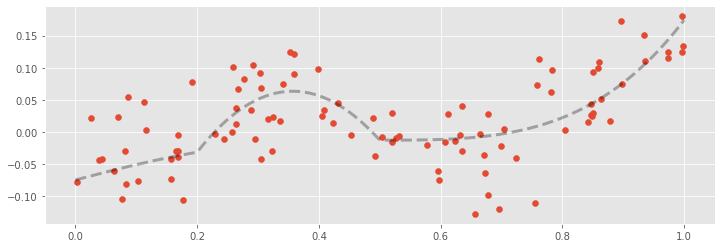

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
t = np.linspace(0, 1, num=250)

ax.scatter(x, y)
ax.plot(t, signal(t), linewidth=3, linestyle="--", 
        color="black", alpha=0.3)

# Regresión a trozos con variables ficticias ("dummy" en inglés).

In [16]:
def make_binned_regression(n_cuts):
    return Pipeline([
        ('binner', Binner(0, 1, n_cuts=n_cuts)),
        ('regression', LinearRegression(fit_intercept=False))
    ])

regressions = {}
for n_cuts in range(1, 24):
    regressions[n_cuts] = make_binned_regression(n_cuts)
    regressions[n_cuts].fit(x, y)

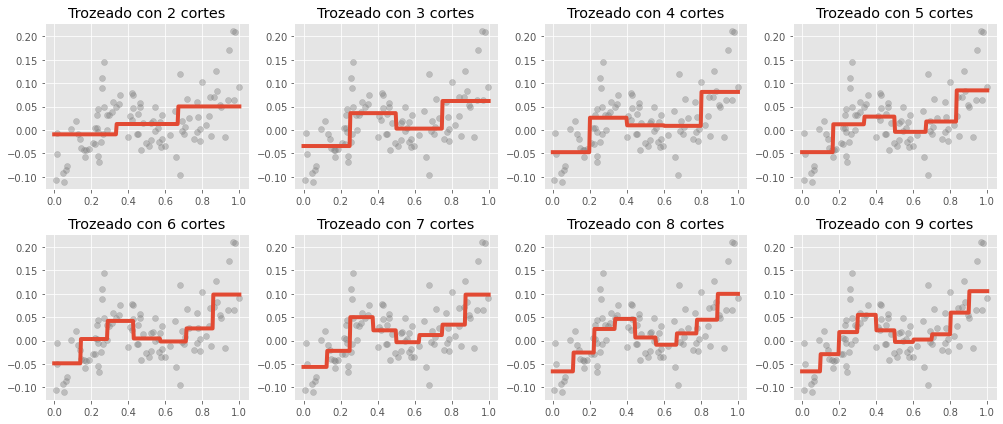

In [16]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6))

t = np.linspace(0, 1, 250)
for n_cuts, ax in enumerate(ax.flatten(), start=2):
    ax.plot(t, regressions[n_cuts].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.4, color="grey")
    ax.set_title("Trozeado con {} cortes".format(n_cuts))

fig.tight_layout()

Text(0.5, 1.0, 'Regresión troceada vs. Señal real')

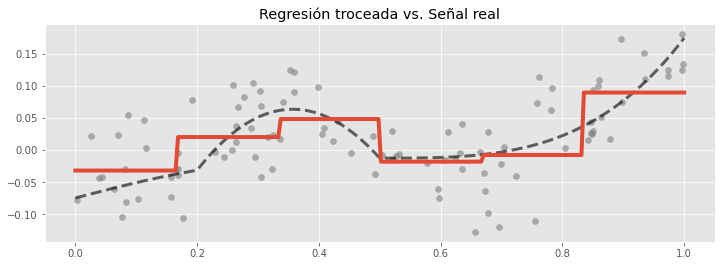

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))
t = np.linspace(0, 1, num=250)

ax.scatter(x, y, alpha=0.6, color="grey")
ax.plot(t, signal(t), linewidth=3, linestyle="--", 
        color="black", alpha=0.6)
ax.plot(t, regressions[5].predict(t.reshape(-1, 1)), linewidth=4)
ax.set_title("Regresión troceada vs. Señal real")

# Regresión con funciones de base con núcleo Gausiano.

In [18]:
def make_gaussian_regression(n_centers):
    return Pipeline([
        ('binner', GaussianKernel(0, 1, n_centers=n_centers, bandwidth=0.1)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

regressions = {}
for n_centers in range(2, 10):
    regressions[n_centers] = make_gaussian_regression(n_centers)
    regressions[n_centers].fit(x, y)

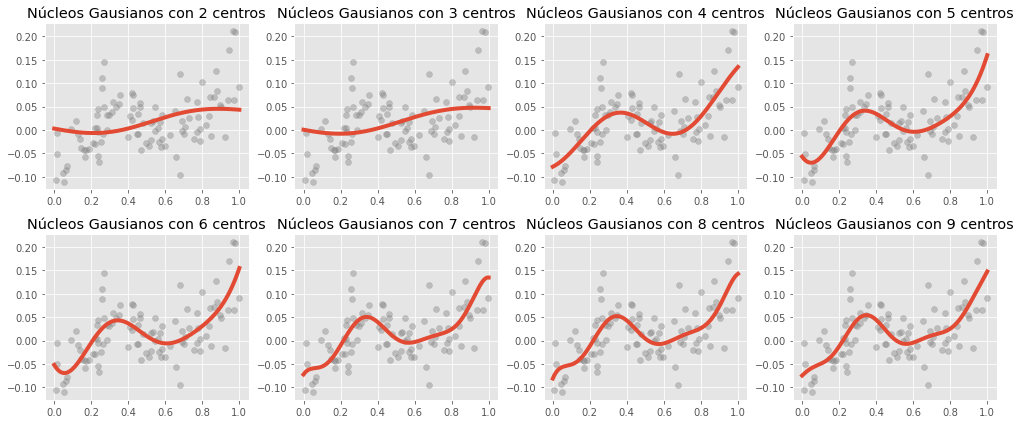

In [19]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6))

t = np.linspace(0, 1, 250)
for n_centers, ax in enumerate(ax.flatten(), start=2):
    ax.plot(t, regressions[n_centers].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.4, color="grey")
    ax.set_title("Núcleos Gausianos con {} centros".format(n_centers))

fig.tight_layout()

Text(0.5, 1.0, 'Regresión con Núcleos Gausianos vs. Señal real')

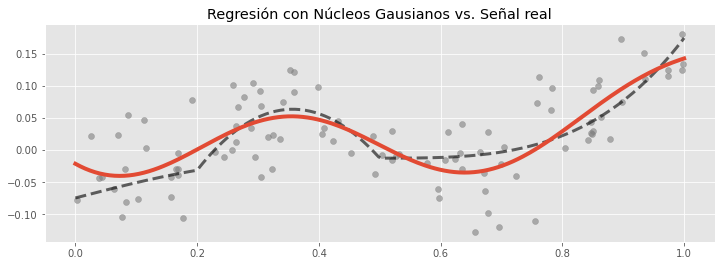

In [19]:
fig, ax = plt.subplots(figsize=(12, 4))
t = np.linspace(0, 1, num=250)

ax.scatter(x, y, alpha=0.6, color="grey")
ax.plot(t, signal(t), linewidth=3, linestyle="--", 
        color="black", alpha=0.6)
ax.plot(t, regressions[6].predict(t.reshape(-1, 1)), linewidth=4)
ax.set_title("Regresión con Núcleos Gausianos vs. Señal real")

# Regresión con expansiones polinomiales

In [20]:
def make_polynomial_regression(degree):
    return Pipeline([
        ('std', StandardScaler()),
        ('poly', Polynomial(degree=degree)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

regressions = {}
for degree in range(1, 30):
    regressions[degree] = make_polynomial_regression(degree)
    regressions[degree].fit(x.reshape(-1, 1), y)

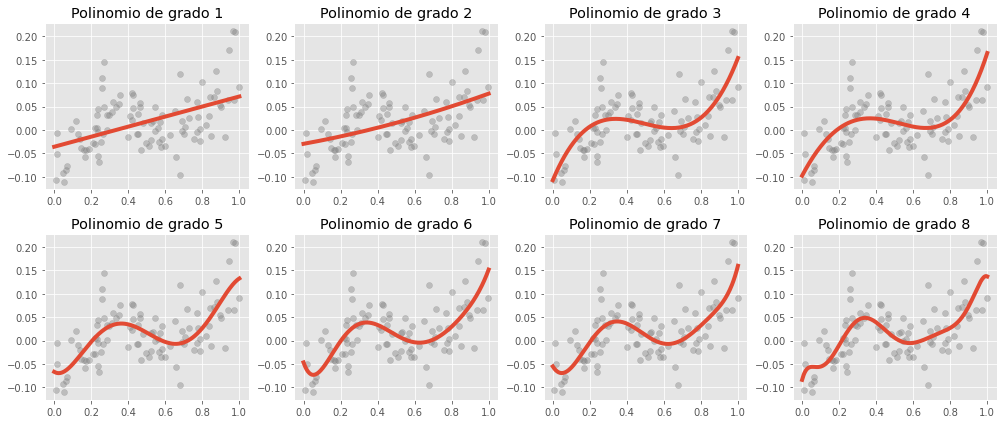

In [22]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6))

t = np.linspace(0, 1, 250)
for i, ax in enumerate(ax.flatten()):
    degree = i + 1
    ax.plot(t, regressions[degree].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.4, color="grey")
    ax.set_title("Polinomio de grado {}".format(degree))
    
fig.tight_layout()

Text(0.5, 1.0, 'Regresiones Polinomiales usando varios grados')

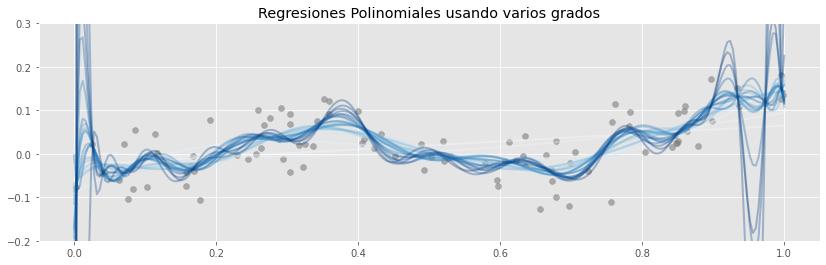

In [21]:
fig, ax = plt.subplots(figsize=(14, 4))

from matplotlib import cm

ax.scatter(x, y, alpha=0.6, color="grey")
colors = [cm.Blues(t) for t in np.linspace(0.0, 1.0, 30)]

for i, degree in enumerate(range(1, 30)):
    ax.plot(t, regressions[degree].predict(t.reshape(-1, 1)), 
            linewidth=2, alpha=0.33, color=colors[i])
ax.set_ylim(-0.2, 0.3)
ax.set_title("Regresiones Polinomiales usando varios grados")

In [22]:
degrees = [5, 10, 20]
regressors = [make_polynomial_regression(degree) for degree in degrees]
test_xs, test_errors = run_residual_simulation(signal, regressors, 50, 100)

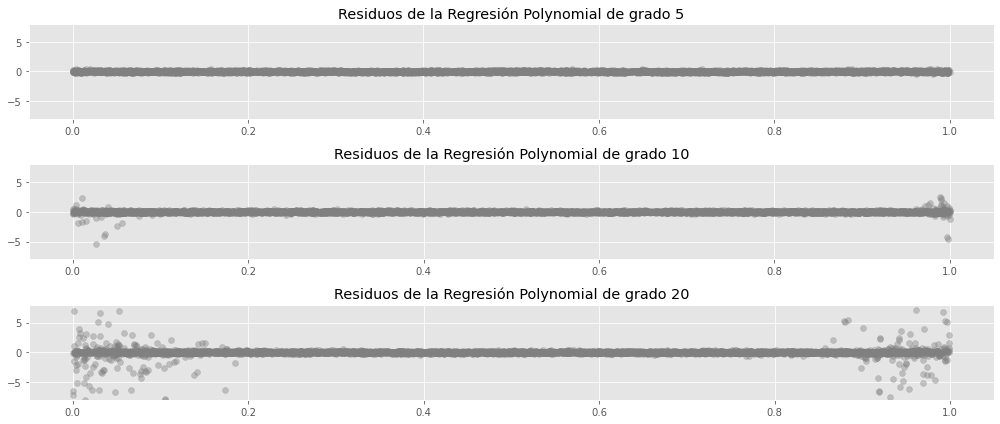

In [23]:
fig, axs = plt.subplots(len(degrees), figsize=(14, 6))

for (i, degree), sim in product(enumerate(degrees), range(100)):
    axs[i].scatter(test_xs[i, sim, :], test_errors[i, sim, :], color="grey", alpha=0.4)
    axs[i].set_title("Residuos de la Regresión Polynomial de grado {}".format(degree))
    axs[i].set_ylim(-8, 8)
fig.tight_layout()

# Regresión con expansiones lineales/polinomiales a trozos ("piecewise linear/polynomial" en inglés)

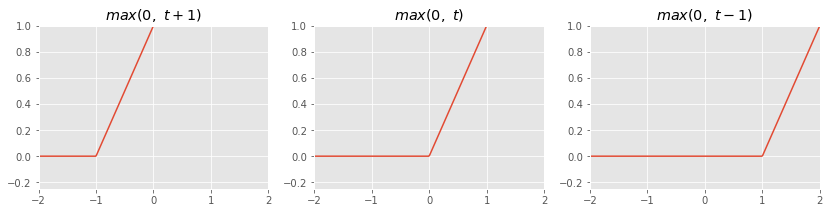

In [24]:
t = np.linspace(-2, 2, num=250)
knots = [-1, 0, 1]
titles = ["$max(0, \ t + 1)$", "$max(0, \ t)$", "$max(0, \ t - 1)$"]

fig, axs = plt.subplots(1, 3, figsize=(14, 3))

for i, (knot, title) in enumerate(zip(knots, titles)):
    axs[i].plot(t, np.maximum(0, t - knot))
    axs[i].set_ylim(-0.25, 1)
    axs[i].set_xlim(-2, 2)
    axs[i].set_title(title)

Text(0.5, 1.0, '$max(0, \\ t + 1) - max(0, \\ t) - 3 max(0, \\ t - 1)$')

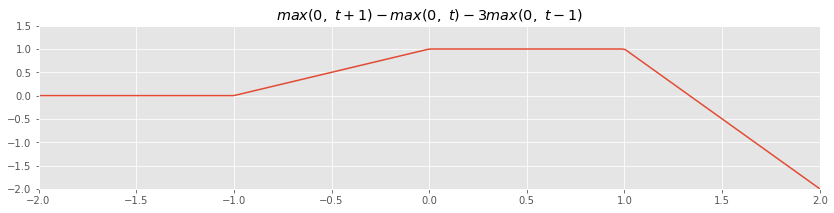

In [25]:
fig, ax = plt.subplots(figsize=(14, 3))

ax.plot(t, np.maximum(0, t + 1) - np.maximum(0, t) - 3*np.maximum(0, t - 1))
ax.set_ylim(-2, 1.5)
ax.set_xlim(-2, 2)
ax.set_title("$max(0, \ t + 1) - max(0, \ t) - 3 max(0, \ t - 1)$")

In [26]:
def make_pl_regression(n_knots):
    return Pipeline([
        ('pl', LinearSpline(0, 1, n_knots=n_knots)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

regressions = {}
for n_knots in range(2, 25):
    regressions[n_knots] = make_pl_regression(n_knots)
    regressions[n_knots].fit(x.reshape(-1, 1), y)

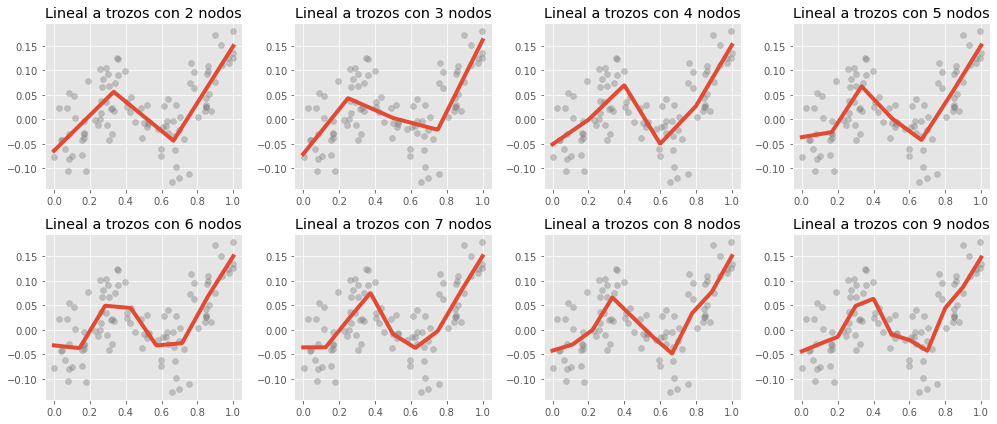

In [27]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6))

t = np.linspace(0, 1, 250)
for i, ax in enumerate(ax.flatten()):
    n_knots = i + 2
    ax.plot(t, regressions[n_knots].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.4, color="grey")
    ax.set_title("Lineal a trozos con {} nodos".format(n_knots))
    
fig.tight_layout()

In [28]:
n_knots = [5, 10, 20]
regressors = [make_pl_regression(n_knot) for n_knot in n_knots]
test_xs, test_errors = run_residual_simulation(signal, regressors, 50, 100)

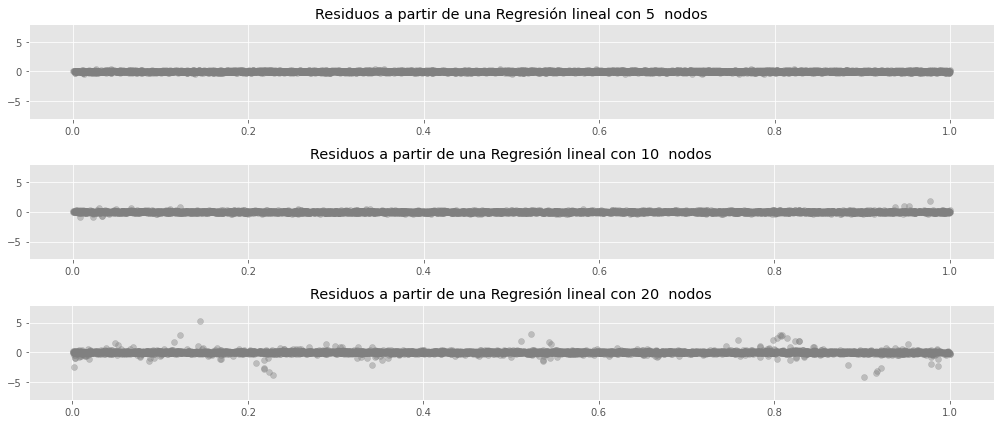

In [29]:
fig, axs = plt.subplots(len(degrees), figsize=(14, 6))

for (i, n_knot), sim in product(enumerate(n_knots), range(100)):
    axs[i].scatter(test_xs[i, sim, :], test_errors[i, sim, :], color="grey", alpha=0.4)
    axs[i].set_title("Residuos a partir de una Regresión lineal con {}  nodos".format(n_knot))
    axs[i].set_ylim(-8, 8)
fig.tight_layout()

# Regresión con expansiones cúbicas a trozos ("piecewise cubic" en inglés)

In [30]:
def make_pw_cubic_regression(n_knots):
    return Pipeline([
        ('pw_cubic', CubicSpline(0, 1, n_knots=n_knots)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

regressions = {}
for n_knots in range(2, 25):
    regressions[n_knots] = make_pw_cubic_regression(n_knots)
    regressions[n_knots].fit(x.reshape(-1, 1), y)

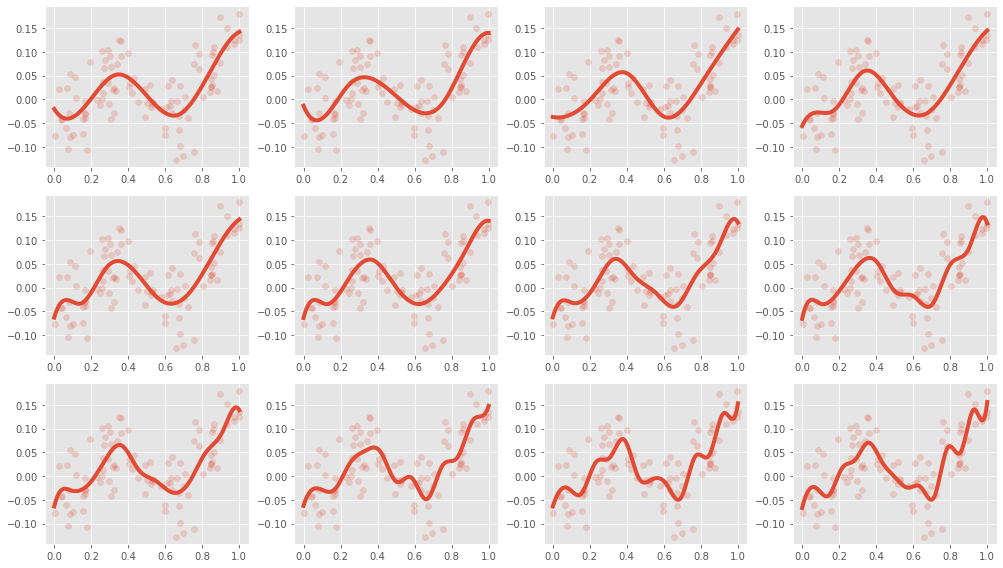

In [31]:
fig, ax = plt.subplots(3, 4, figsize=(14, 8))

t = np.linspace(0, 1, 250)
for i, ax in enumerate(ax.flatten()):
    n_knots = i + 2
    ax.plot(t, regressions[n_knots].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.2)


    
fig.tight_layout()

# Regresión con expansiones cúbicas a trozos (usando splines cúbicos naturales)

In [32]:
def make_natural_cubic_regression(n_knots):
    return Pipeline([
        ('nat_cubic', NaturalCubicSpline(0, 1, n_knots=n_knots)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

regressions = {}
for n_knots in range(2, 25):
    regressions[n_knots] = make_natural_cubic_regression(n_knots)
    regressions[n_knots].fit(x.reshape(-1, 1), y)

Text(0.5, 1.0, 'Spline cúbico natural con los nodos indicados')

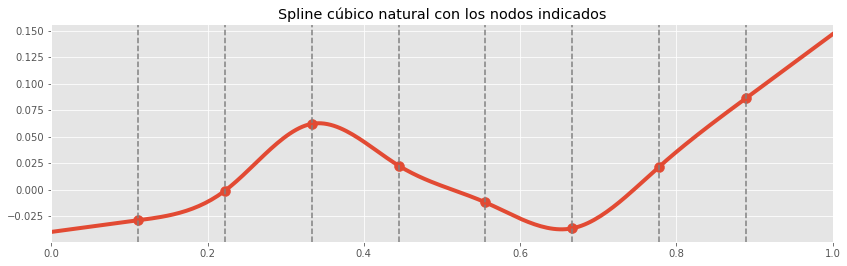

In [33]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(t, regressions[8].predict(t.reshape(-1, 1)), linewidth=4)

knots = regressions[8].get_params()['nat_cubic__knots']
ax.scatter([knots], regressions[8].predict(np.array(knots).reshape(-1, 1)), s=100)

for knot in knots:
    ax.axvline(knot, linestyle='--', color='grey')
ax.set_xlim(0, 1)
ax.set_title("Spline cúbico natural con los nodos indicados")

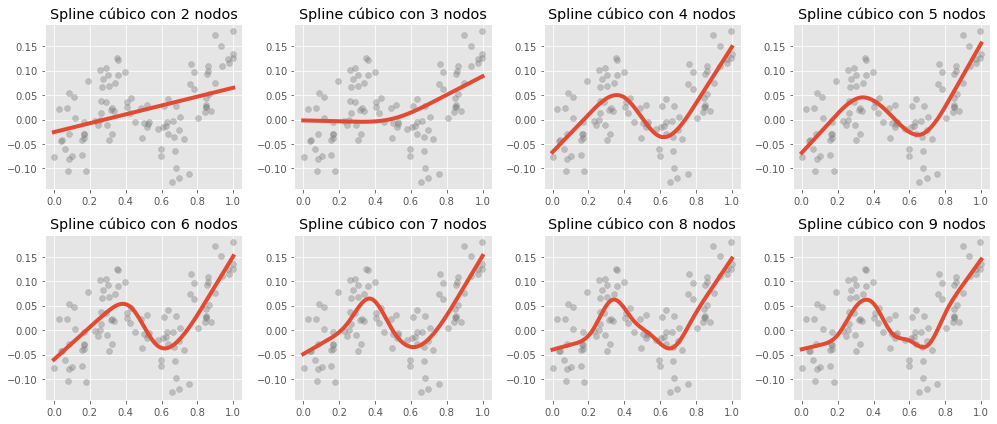

In [34]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6))

t = np.linspace(0, 1, 250)
for i, ax in enumerate(ax.flatten()):
    n_knots = i + 2
    ax.plot(t, regressions[n_knots].predict(t.reshape(-1, 1)), linewidth=4)
    ax.scatter(x, y, alpha=0.4, color="grey")
    ax.set_title("Spline cúbico con {} nodos".format(n_knots))

fig.tight_layout()

In [35]:
n_knots = [5, 10, 20]
regressors = [make_natural_cubic_regression(n_knot) for n_knot in n_knots]
test_xs, test_errors = run_residual_simulation(signal, regressors, 50, 100)

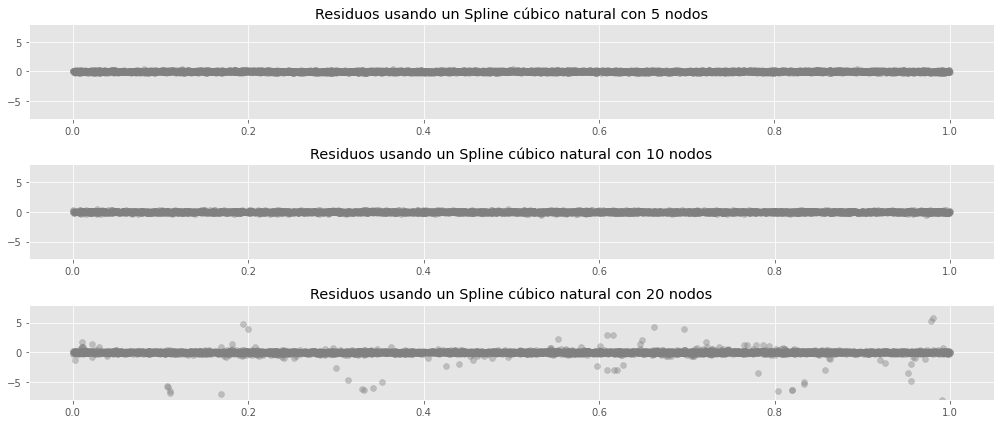

In [36]:
fig, axs = plt.subplots(len(degrees), figsize=(14, 6))

for (i, n_knot), sim in product(enumerate(n_knots), range(100)):
    axs[i].scatter(test_xs[i, sim, :], test_errors[i, sim, :], color="grey", alpha=0.4)
    axs[i].set_title("Residuos usando un Spline cúbico natural con {} nodos".format(n_knot))
    axs[i].set_ylim(-8, 8)
fig.tight_layout()

## Ejemplos variados

In [37]:
regressions = [
    {'model': make_binned_regression(5), 
         'title': "Expansion troceada, 6 trozos"},
    
    {'model': make_gaussian_regression(5), 
         'title': "Expansion con núcleos Gausianos, 5 centros"},
    
    {'model': make_polynomial_regression(6) , 
         'title': "Regresión Polinomial, grado 6"},
    
    {'model': make_pl_regression(6), 
          'title': "Spline Lineal, 6 nodos"},

    {'model': make_pw_cubic_regression(6) , 
         'title': "Spline Cúbica, 6 nodos"},

    {'model': make_natural_cubic_regression(6), 
         'title': "Spline Cúbica Natural, 6 nodos"}
]

for reg in regressions:
    reg['model'].fit(x.reshape(-1, 1), y)

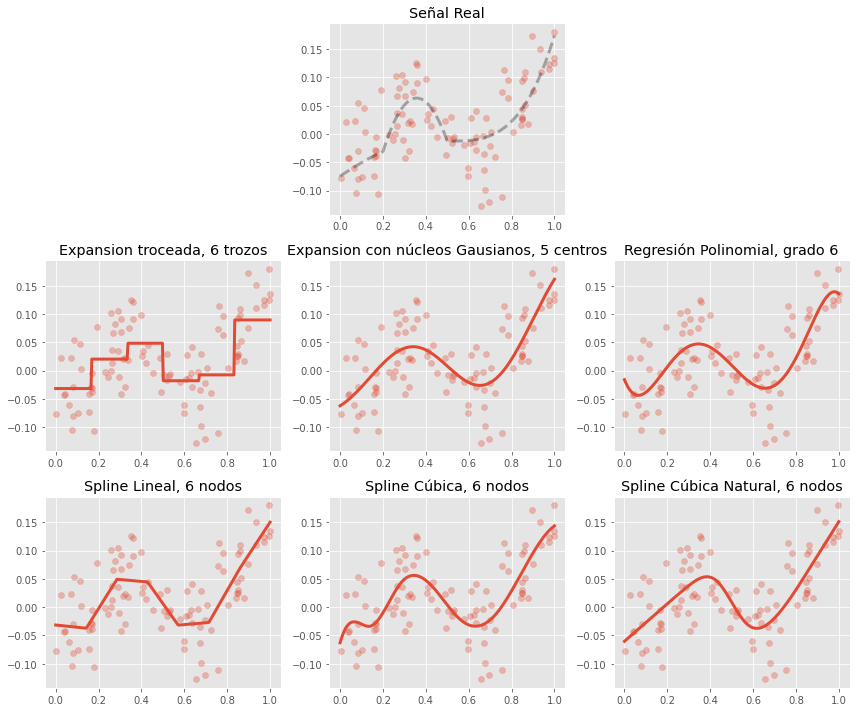

In [38]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))

axs[0, 1].scatter(x, y, alpha=0.33)
axs[0, 1].plot(t, signal(t), linewidth=3, linestyle="--", 
               color="black", alpha=0.3)
axs[0, 1].set_title("Señal Real")

axs[0, 0].axis('off')
axs[0, 2].axis('off')

for i, ax in enumerate(axs[1:, :].flatten()):
    ax.scatter(x, y, alpha=0.33)
    ax.plot(t, regressions[i]['model'].predict(t.reshape(-1, 1)), linewidth=3)
    ax.set_title(regressions[i]['title'])
    
fig.tight_layout()

## Investigando el Rendimiento con Diferentes Suavizadores

In [39]:
def linear_signal(x):
    return x

def sin_signal(x):
    return np.sin(2*np.pi*x)

cutpoints = sorted(np.random.uniform(size=6))
def broken_sin_signal(x):
    return  (np.sin(2*np.pi*x) 
             - (cutpoints[0] <= x)*(x <= cutpoints[2]) 
             - (cutpoints[1] <= x)*(x <= cutpoints[2])
             - 2*(cutpoints[3] <= x)*(x <= cutpoints[4]))

def weird_signal(x):
    return (x*x*x*(x-1) 
            + 2*(1/(1 + np.exp(-0.5*(x - 0.5)))) 
            - 3.5*(x > 0.2)*(x < 0.5)*(x - 0.2)*(x - 0.5)
            - 0.95)

In [40]:
degrees_of_freedom = list(range(2, 30))

def make_binned_regression(n_params):
    return Pipeline([
        ('binner', Binner(0, 1, n_params=n_params)),
        ('regression', LinearRegression(fit_intercept=False))
    ])

def make_polynomial_regression(n_params):
    return Pipeline([
        ('std', StandardScaler()),
        ('poly', Polynomial(n_params=n_params)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

def make_pl_regression(n_params):
    return Pipeline([
        ('pl', LinearSpline(0, 1, n_params=n_params)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

def make_natural_cubic_regression(n_params):
    return Pipeline([
        ('nat_cubic', NaturalCubicSpline(0, 1, n_params=n_params)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

def make_non_linear_regressions(regression_maker, degrees_of_freedom):
    return [regression_maker(dof) for dof in degrees_of_freedom]

binned_regressors = make_non_linear_regressions(make_binned_regression,
                                                degrees_of_freedom)
polynomial_regressors = make_non_linear_regressions(make_polynomial_regression,
                                                    degrees_of_freedom)
pl_regressors = make_non_linear_regressions(make_pl_regression,
                                            degrees_of_freedom)
ncs_regressors = make_non_linear_regressions(make_natural_cubic_regression,
                                             degrees_of_freedom)

regressors = {
    "binned": binned_regressors,
    "polynomial": polynomial_regressors,
    "pl": pl_regressors,
    "ncs": ncs_regressors
}

## Ajustando a una  Señal Lineal

Text(0.5, 1.0, 'Función Lineal + Ruido Gausiano')

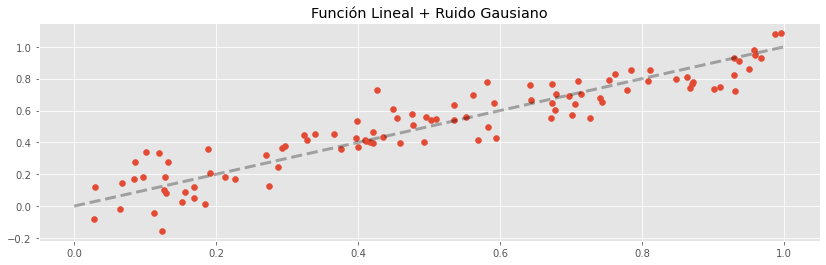

In [41]:
fig, ax = plt.subplots(figsize=(14, 4))
t = np.linspace(0, 1, num=250)

x = np.random.uniform(size=100)
y = linear_signal(x) + np.random.normal(scale=0.1, size=100)
ax.scatter(x, y)
ax.plot(t, linear_signal(t), linewidth=3, linestyle="--", 
        color="black", alpha=0.3)

ax.set_title("Función Lineal + Ruido Gausiano")

In [42]:
binned_mean_errors, binned_std_errors = run_simulation_expreiment(
    linear_signal, binned_regressors, sd=0.5)
polynomial_mean_errors, polynomial_std_errors = run_simulation_expreiment(
    linear_signal, polynomial_regressors, sd=0.5)
pl_mean_errors, pl_std_errors = run_simulation_expreiment(
    linear_signal, pl_regressors, sd=0.5)
ncs_mean_errors, ncs_std_errors = run_simulation_expreiment(
    linear_signal, ncs_regressors, sd=0.5)

Text(0, 0.5, 'Error Cuadrático Medio')

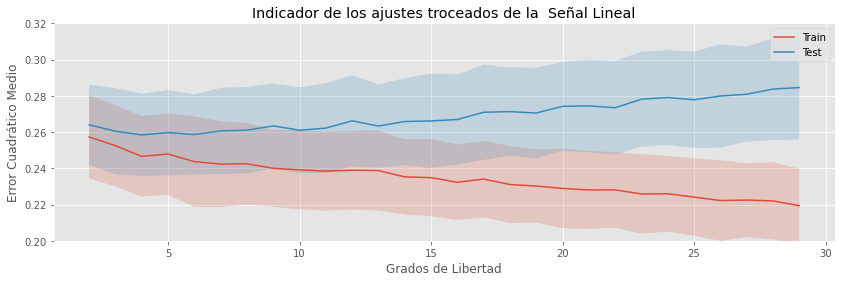

In [43]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax, 
    degrees_of_freedom, binned_mean_errors, binned_std_errors)
ax.set_ylim(0.2, 0.32)
ax.set_title("Indicador de los ajustes troceados de la  Señal Lineal")
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Cuadrático Medio")

Text(0, 0.5, 'Error Cuadrático Medio')

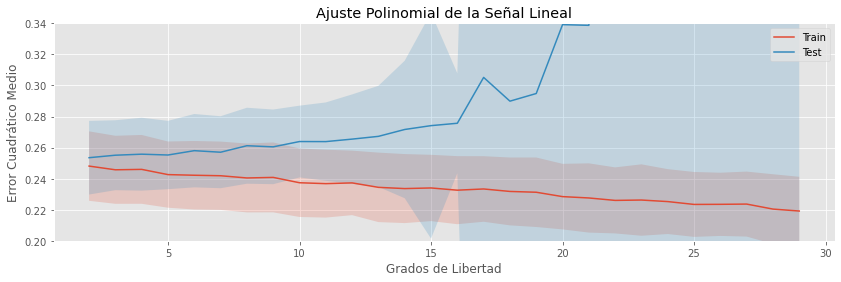

In [44]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, polynomial_mean_errors, polynomial_std_errors)
ax.set_ylim(0.2, 0.34)
ax.set_title("Ajuste Polinomial de la Señal Lineal")
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Cuadrático Medio")

Text(0, 0.5, 'Error Cuadrático Medio')

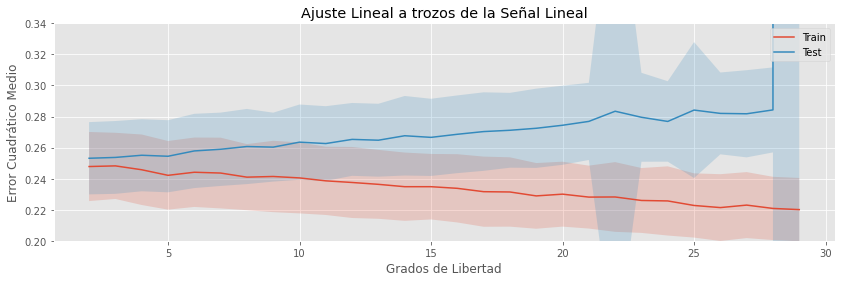

In [45]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, pl_mean_errors, pl_std_errors)
ax.set_ylim(0.2, 0.34)
ax.set_title("Ajuste Lineal a trozos de la Señal Lineal")
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Cuadrático Medio")

Text(0, 0.5, 'Error Cuadrático Medio')

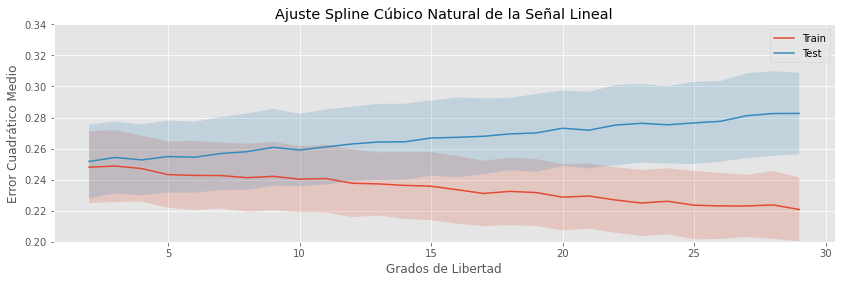

In [46]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, ncs_mean_errors, ncs_std_errors)
ax.set_ylim(0.2, 0.34)
ax.set_title("Ajuste Spline Cúbico Natural de la Señal Lineal")
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Cuadrático Medio")

Text(0.5, 1.0, 'Comparación del Error de retención para diferentes Bases')

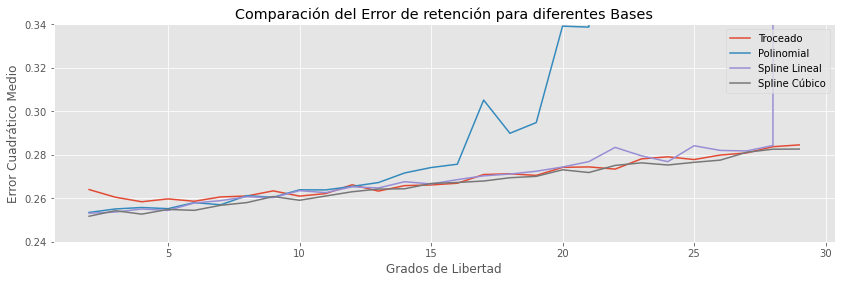

In [47]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(degrees_of_freedom, binned_mean_errors[1], label="Troceado")
ax.plot(degrees_of_freedom, polynomial_mean_errors[1], label="Polinomial")
ax.plot(degrees_of_freedom, pl_mean_errors[1], label="Spline Lineal")
ax.plot(degrees_of_freedom, ncs_mean_errors[1], label="Spline Cúbico")
ax.set_ylim(0.24, 0.34)

ax.legend()
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Cuadrático Medio")
ax.set_title("Comparación del Error de retención para diferentes Bases")

Text(0.5, 1.0, 'Comparación del Error de retención de la varianza para diferentes Bases')

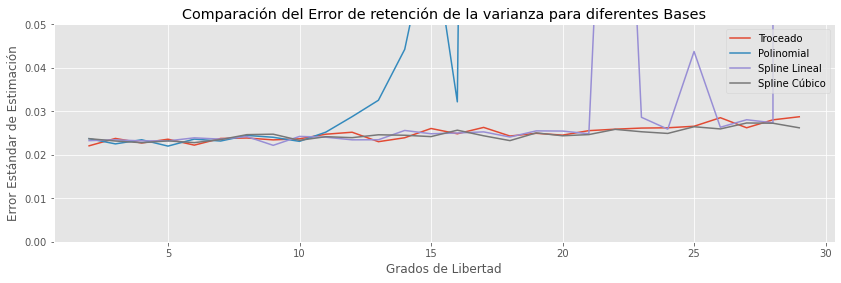

In [48]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(degrees_of_freedom, binned_std_errors[1], label="Troceado")
ax.plot(degrees_of_freedom, polynomial_std_errors[1], label="Polinomial")
ax.plot(degrees_of_freedom, pl_std_errors[1], label="Spline Lineal")
ax.plot(degrees_of_freedom, ncs_std_errors[1], label="Spline Cúbico")
ax.set_ylim(0.0, 0.05)

ax.legend()
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Estándar de Estimación")
ax.set_title("Comparación del Error de retención de la varianza para diferentes Bases")

## Ajustando una Señal Sinusoidal

Text(0.5, 1.0, 'Función Sinusoidal + Ruido Gausiano')

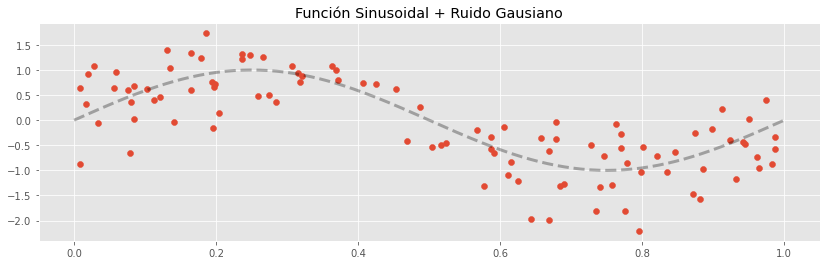

In [49]:
fig, ax = plt.subplots(figsize=(14, 4))
t = np.linspace(0, 1, num=250)

x = np.random.uniform(size=100)
y = sin_signal(x) + np.random.normal(scale=0.5, size=100)
ax.scatter(x, y)
ax.plot(t, sin_signal(t), linewidth=3, linestyle="--", 
        color="black", alpha=0.3)
ax.set_title("Función Sinusoidal + Ruido Gausiano")

In [50]:
binned_mean_errors, binned_std_errors = run_simulation_expreiment(
    sin_signal, binned_regressors, sd=0.5)
polynomial_mean_errors, polynomial_std_errors = run_simulation_expreiment(
    sin_signal, polynomial_regressors, sd=0.5)
pl_mean_errors, pl_std_errors = run_simulation_expreiment(
    sin_signal, pl_regressors, sd=0.5)
ncs_mean_errors, ncs_std_errors = run_simulation_expreiment(
    sin_signal, ncs_regressors, sd=0.5)

Text(0, 0.5, 'Error Cuadrático Medio')

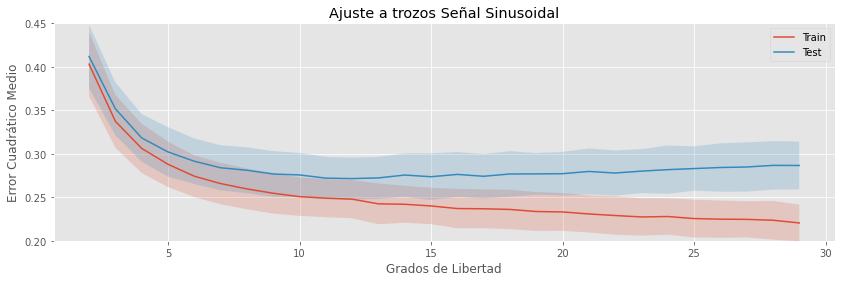

In [51]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax, 
    degrees_of_freedom, binned_mean_errors, binned_std_errors)
ax.set_ylim(0.2, 0.45)
ax.set_title("Ajuste a trozos Señal Sinusoidal")
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Cuadrático Medio")

Text(0, 0.5, 'Error Cuadrático Medio')

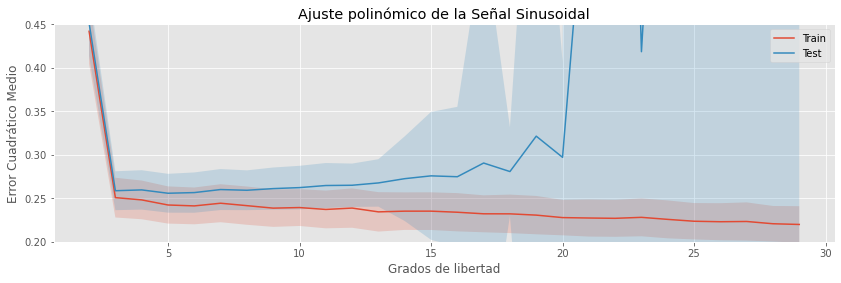

In [52]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, polynomial_mean_errors, polynomial_std_errors)
ax.set_ylim(0.2, 0.45)
ax.set_title("Ajuste polinómico de la Señal Sinusoidal")
ax.set_xlabel("Grados de libertad")
ax.set_ylabel("Error Cuadrático Medio")

Text(0, 0.5, 'Error Cuadrático Medio')

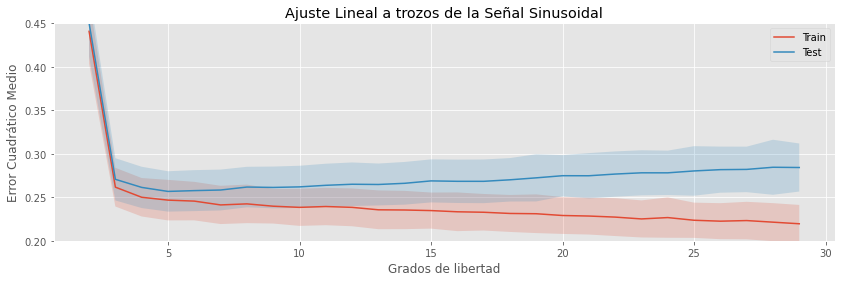

In [53]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, pl_mean_errors, pl_std_errors)
ax.set_ylim(0.2, 0.45)
ax.set_title("Ajuste Lineal a trozos de la Señal Sinusoidal")
ax.set_xlabel("Grados de libertad")
ax.set_ylabel("Error Cuadrático Medio")

Text(0, 0.5, 'Error Cuadrático Medio')

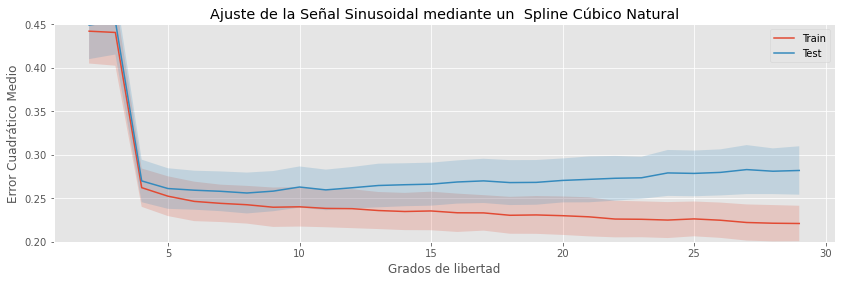

In [54]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, ncs_mean_errors, ncs_std_errors)
ax.set_ylim(0.2, 0.45)
ax.set_title("Ajuste de la Señal Sinusoidal mediante un  Spline Cúbico Natural")
ax.set_xlabel("Grados de libertad")
ax.set_ylabel("Error Cuadrático Medio")

Text(0.5, 1.0, 'Comparación del Error de retención para diferentes Bases')

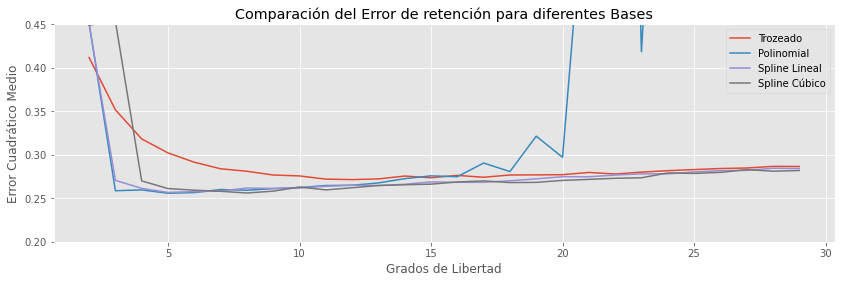

In [55]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(degrees_of_freedom, binned_mean_errors[1], label="Trozeado")
ax.plot(degrees_of_freedom, polynomial_mean_errors[1], label="Polinomial")
ax.plot(degrees_of_freedom, pl_mean_errors[1], label="Spline Lineal")
ax.plot(degrees_of_freedom, ncs_mean_errors[1], label="Spline Cúbico")
ax.set_ylim(0.2, 0.45)

ax.legend()
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Cuadrático Medio")
ax.set_title("Comparación del Error de retención para diferentes Bases")

Text(0.5, 1.0, 'Comparación del Error de retención de la varianza para diferentes Bases')

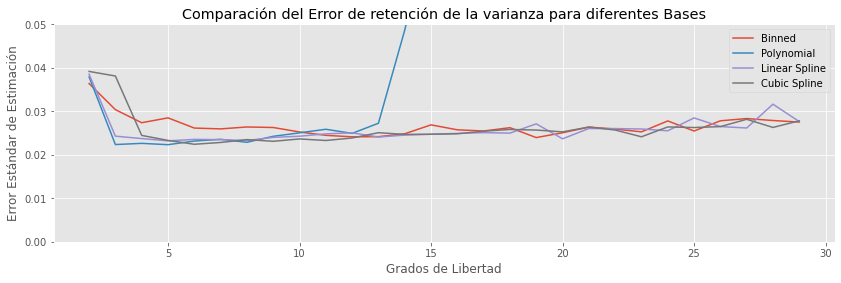

In [56]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(degrees_of_freedom, binned_std_errors[1], label="Binned")
ax.plot(degrees_of_freedom, polynomial_std_errors[1], label="Polynomial")
ax.plot(degrees_of_freedom, pl_std_errors[1], label="Linear Spline")
ax.plot(degrees_of_freedom, ncs_std_errors[1], label="Cubic Spline")
ax.set_ylim(0.0, 0.05)

ax.legend()
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Estándar de Estimación")
ax.set_title("Comparación del Error de retención de la varianza para diferentes Bases")

## Ajuste de una Señal Sinusoidal Discontinua

Text(0.5, 1.0, 'Función Sinusoidal Discontinua + Ruido Gausiano')

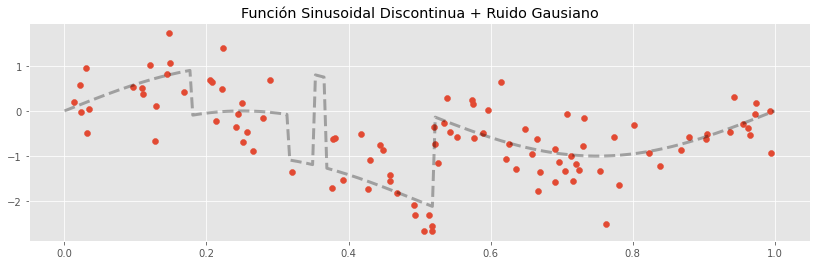

In [57]:
fig, ax = plt.subplots(figsize=(14, 4))
t = np.linspace(0, 1, num=250)

x = np.random.uniform(size=100)
y = broken_sin_signal(x) + np.random.normal(scale=0.5, size=100)
ax.scatter(x, y)
ax.plot(t, broken_sin_signal(t), linewidth=3, linestyle="--", 
        color="black", alpha=0.3)
ax.set_title("Función Sinusoidal Discontinua + Ruido Gausiano")

In [58]:
binned_mean_errors, binned_std_errors = run_simulation_expreiment(
    broken_sin_signal, binned_regressors, sd=0.05)
polynomial_mean_errors, polynomial_std_errors = run_simulation_expreiment(
    broken_sin_signal, polynomial_regressors, sd=0.05)
pl_mean_errors, pl_std_errors = run_simulation_expreiment(
    broken_sin_signal, pl_regressors, sd=0.05)
ncs_mean_errors, ncs_std_errors = run_simulation_expreiment(
    broken_sin_signal, ncs_regressors, sd=0.05)

Text(0, 0.5, 'Error Cuadrático Medio')

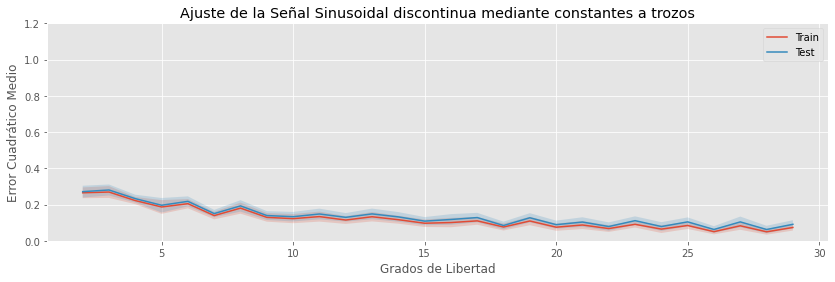

In [59]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax, 
    degrees_of_freedom, binned_mean_errors, binned_std_errors)
ax.set_ylim(0.0, 1.2)
ax.set_title("Ajuste de la Señal Sinusoidal discontinua mediante constantes a trozos")
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Cuadrático Medio")

Text(0, 0.5, 'Error Cuadrático Medio')

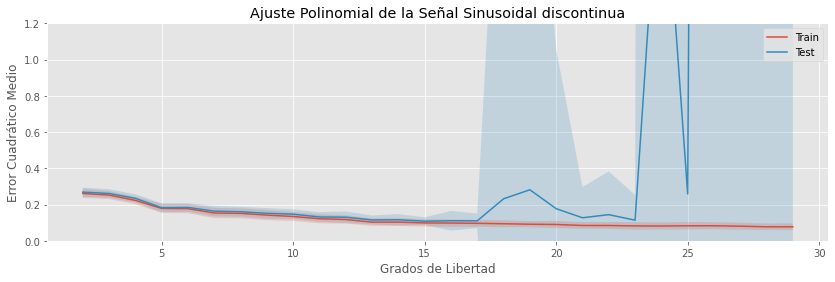

In [60]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, polynomial_mean_errors, polynomial_std_errors)
ax.set_ylim(0.0, 1.2)
ax.set_title("Ajuste Polinomial de la Señal Sinusoidal discontinua")
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Cuadrático Medio")

Text(0, 0.5, 'Error Cuadrático Medio')

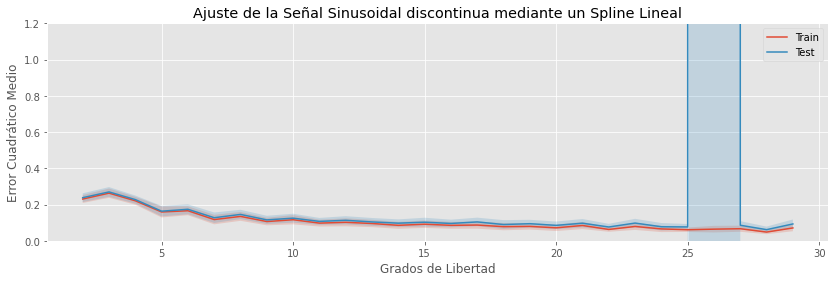

In [61]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, pl_mean_errors, pl_std_errors)
ax.set_ylim(0.0, 1.2)
ax.set_title("Ajuste de la Señal Sinusoidal discontinua mediante un Spline Lineal")
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Cuadrático Medio")

Text(0, 0.5, 'Error Cuadrático Medio')

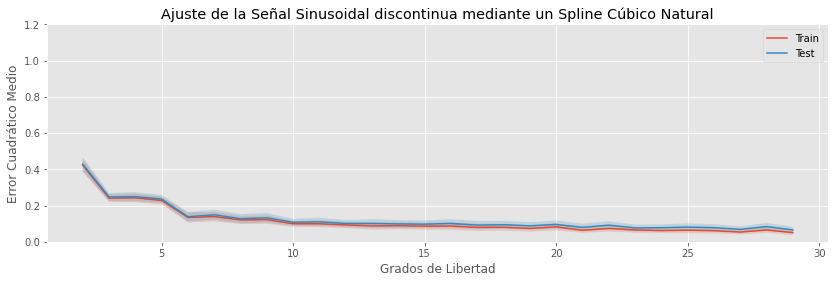

In [62]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, ncs_mean_errors, ncs_std_errors)
ax.set_ylim(0.0, 1.2)
ax.set_title("Ajuste de la Señal Sinusoidal discontinua mediante un Spline Cúbico Natural")
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Cuadrático Medio")

Text(0.5, 1.0, 'Comparación del Error de retención para diferentes Bases')

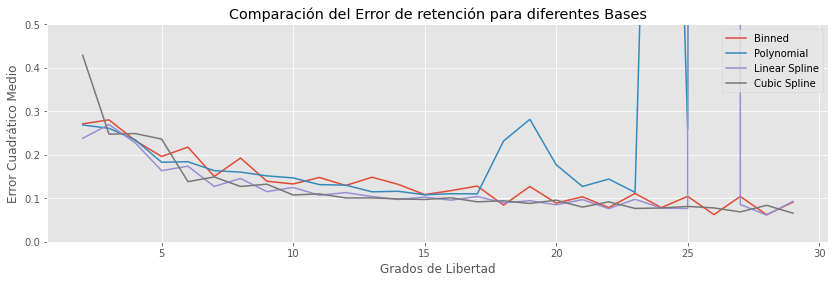

In [63]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(degrees_of_freedom, binned_mean_errors[1], label="Binned")
ax.plot(degrees_of_freedom, polynomial_mean_errors[1], label="Polynomial")
ax.plot(degrees_of_freedom, pl_mean_errors[1], label="Linear Spline")
ax.plot(degrees_of_freedom, ncs_mean_errors[1], label="Cubic Spline")
ax.set_ylim(0.0, 0.5)

ax.legend()
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Cuadrático Medio")
ax.set_title("Comparación del Error de retención para diferentes Bases")

Text(0.5, 1.0, 'Comparación de las variaciones de error de retención para diferentes Bases')

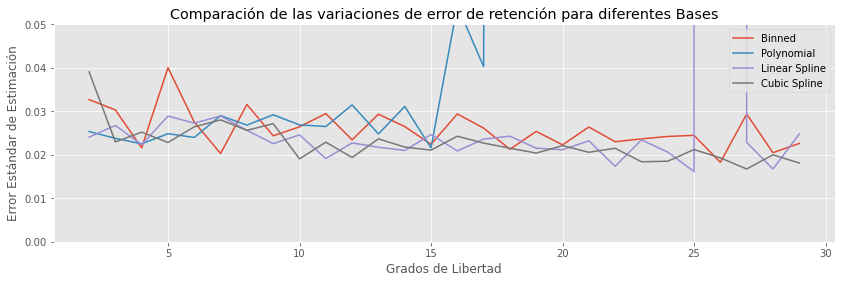

In [64]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(degrees_of_freedom, binned_std_errors[1], label="Binned")
ax.plot(degrees_of_freedom, polynomial_std_errors[1], label="Polynomial")
ax.plot(degrees_of_freedom, pl_std_errors[1], label="Linear Spline")
ax.plot(degrees_of_freedom, ncs_std_errors[1], label="Cubic Spline")
ax.set_ylim(0.0, 0.05)

ax.legend()
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Estándar de Estimación")
ax.set_title("Comparación de las variaciones de error de retención para diferentes Bases")

## Ajuste de una señal extraña

Text(0.5, 1.0, 'Función Extraña + Ruido Gausiano')

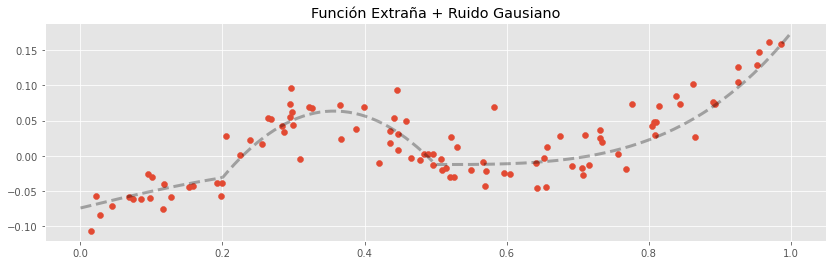

In [65]:
fig, ax = plt.subplots(figsize=(14, 4))
t = np.linspace(0, 1, num=250)

x = np.random.uniform(size=100)
y = weird_signal(x) + np.random.normal(scale=0.025, size=100)
ax.scatter(x, y)
ax.plot(t, weird_signal(t), linewidth=3, linestyle="--", 
        color="black", alpha=0.3)
ax.set_title("Función Extraña + Ruido Gausiano")

In [66]:
binned_mean_errors, binned_std_errors = run_simulation_expreiment(
    weird_signal, binned_regressors, sd=0.05)
polynomial_mean_errors, polynomial_std_errors = run_simulation_expreiment(
    weird_signal, polynomial_regressors, sd=0.05)
pl_mean_errors, pl_std_errors = run_simulation_expreiment(
    weird_signal, pl_regressors, sd=0.05)
ncs_mean_errors, ncs_std_errors = run_simulation_expreiment(
    weird_signal, ncs_regressors, sd=0.05)

Text(0, 0.5, 'Error Cuadrático Medio')

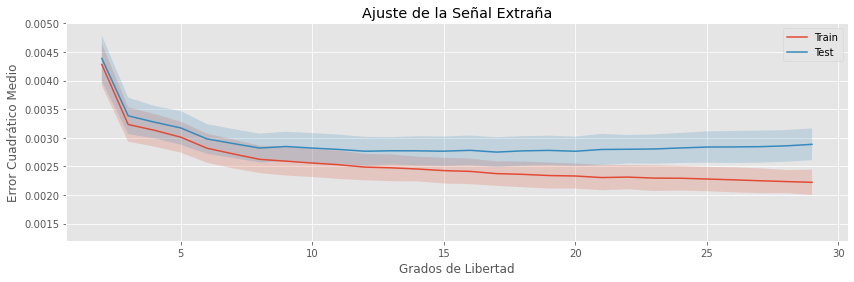

In [67]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax, 
    degrees_of_freedom, binned_mean_errors, binned_std_errors)
ax.set_ylim(0.0012, 0.005)
ax.set_title("Ajuste de la Señal Extraña")
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Cuadrático Medio")

Text(0, 0.5, 'Error Cuadrático Medio')

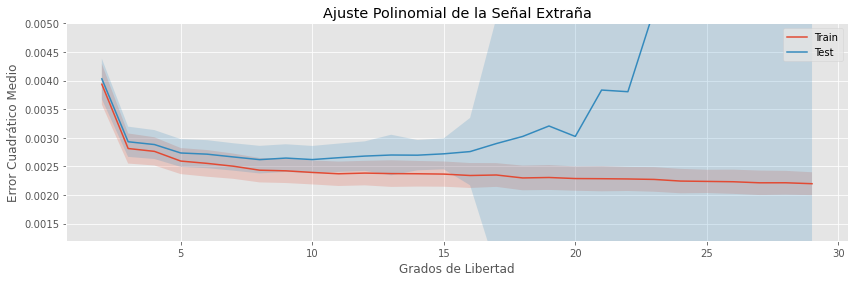

In [68]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, polynomial_mean_errors, polynomial_std_errors)
ax.set_ylim(0.0012, 0.005)
ax.set_title("Ajuste Polinomial de la Señal Extraña")
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Cuadrático Medio")

Text(0, 0.5, 'Error Cuadrático Medio')

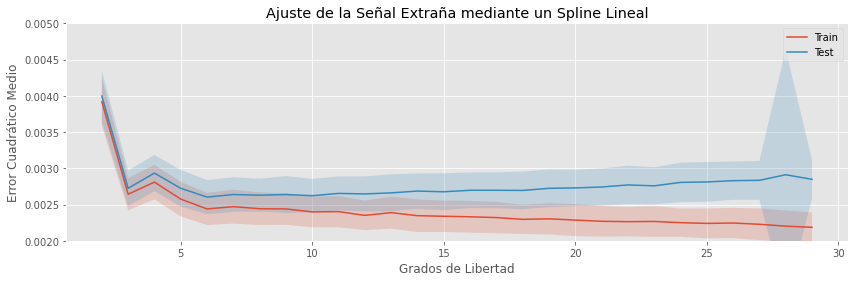

In [69]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, pl_mean_errors, pl_std_errors)
ax.set_ylim(0.002, 0.005)
ax.set_title("Ajuste de la Señal Extraña mediante un Spline Lineal")
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Cuadrático Medio")

Text(0, 0.5, 'Error Cuadrático Medio')

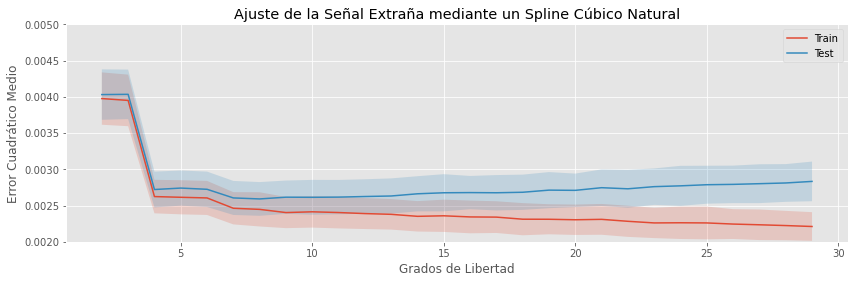

In [70]:
fig, ax = plt.subplots(figsize=(14, 4))
plot_simulation_expreiment(ax,
    degrees_of_freedom, ncs_mean_errors, ncs_std_errors)
ax.set_ylim(0.002, 0.005)
ax.set_title("Ajuste de la Señal Extraña mediante un Spline Cúbico Natural")
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Cuadrático Medio")

Text(0.5, 1.0, 'Comparación del Error de retención para diferentes Bases')

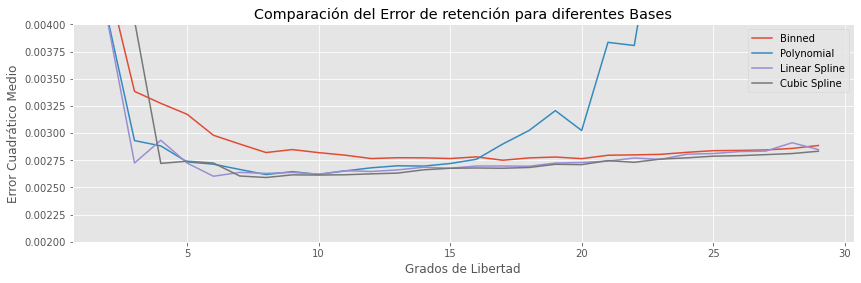

In [71]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(degrees_of_freedom, binned_mean_errors[1], label="Binned")
ax.plot(degrees_of_freedom, polynomial_mean_errors[1], label="Polynomial")
ax.plot(degrees_of_freedom, pl_mean_errors[1], label="Linear Spline")
ax.plot(degrees_of_freedom, ncs_mean_errors[1], label="Cubic Spline")
ax.set_ylim(0.002, 0.004)

ax.legend()
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Cuadrático Medio")
ax.set_title("Comparación del Error de retención para diferentes Bases")

Text(0.5, 1.0, 'Comparación de las variaciones de error de retención para diferentes expansiones de base')

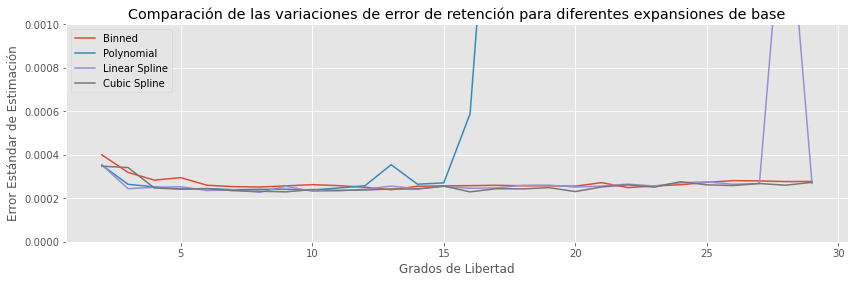

In [72]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(degrees_of_freedom, binned_std_errors[1], label="Binned")
ax.plot(degrees_of_freedom, polynomial_std_errors[1], label="Polynomial")
ax.plot(degrees_of_freedom, pl_std_errors[1], label="Linear Spline")
ax.plot(degrees_of_freedom, ncs_std_errors[1], label="Cubic Spline")
ax.set_ylim(0.0, 0.001)

ax.legend()
ax.set_xlabel("Grados de Libertad")
ax.set_ylabel("Error Estándar de Estimación")
ax.set_title("Comparación de las variaciones de error de retención para diferentes expansiones de base")

In [73]:
%pwd

'C:\\Users\\UX363\\Downloads\\Prácticas sobre splines-20220406\\Splines de Ajuste\\basis-expansions-master\\basis-expansions-master\\examples'